<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/staging/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

- ラベル「0」： airplane（飛行機）
- ラベル「1」： automobile（自動車）
- ラベル「2」： bird（鳥）
- ラベル「3」： cat（猫）
- ラベル「4」： deer（鹿）
- ラベル「5」： dog（犬）
- ラベル「6」： frog（カエル）
- ラベル「7」： horse（馬）
- ラベル「8」： ship（船）
- ラベル「9」： truck（トラック）

# 前処理

In [40]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
import torch.nn.functional as F

In [41]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [42]:
# 前処理をまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右対称にする
    transforms.ColorJitter(), # ランダムに色を変える。
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
vilidation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

In [43]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(vilidation_dataset, batch_size=32, shuffle=False)

In [44]:
# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [45]:
# modelを作成
model = CNN(10) # 10はクラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [46]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [47]:
# 損失関数とoptimizerを設定
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。
# CosineAnnealingWarmRestartsの設定
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=0.)

In [48]:
num_classes=10

In [49]:
# 学習のループ
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs-3):
    total_loss = 0.0 # mixupでは損失の計算方法が異なるため、total_lossに名称変更
    total_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        # こっからmixup
        lmd = np.random.beta(1.0, 1.0)
        idx = torch.randperm(imgs.size(0)).to(device) # ランダムに並び替える
        imgs2 = imgs[idx, :] # 混ぜ合わせる画像
        labels2 = labels[idx]

        labels = F.one_hot(labels, num_classes=num_classes).float()
        labels2 = F.one_hot(labels2, num_classes=num_classes).float()

        # ここまで

        optimizer.zero_grad() # 勾配の初期化
        output = model(lmd * imgs + (1 - lmd) * imgs2) # いじった
        loss = lmd * criterion(output, labels) + (1 - lmd) * criterion(output, labels2) # いじった
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        total_acc += lmd * torch.mean(pred.eq(labels.argmax(dim=1)).float()) + (1 - lmd) * torch.mean(pred.eq(labels2.argmax(dim=1)).float())
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    total_loss /= len(train_dataloader)
    total_acc /= len(train_dataloader)
    losses.append(total_loss)
    #accs.append(running_acc)
    accs.append(total_acc.cpu())
    scheduler.step()
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, total_loss, total_acc, val_running_loss, val_running_acc))




for epoch in range(num_epochs-12):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() # 位置換えてみた
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
    scheduler.step()
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch+12, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.3349728323066379, acc: 0.359985888004303,      val loss: 0.7964676793771811, val acc: 0.5858626365661621
epoch: 1, loss: 1.127001752093749, acc: 0.4717273414134979,      val loss: 0.6268535728652638, val acc: 0.6561501622200012
epoch: 2, loss: 1.01874099432545, acc: 0.5289151668548584,      val loss: 0.5237357822089149, val acc: 0.7032747268676758
epoch: 3, loss: 0.9543268627183833, acc: 0.5589540600776672,      val loss: 0.49286681970658774, val acc: 0.7325279712677002
epoch: 4, loss: 0.897983595051982, acc: 0.5926409363746643,      val loss: 0.4443966502579637, val acc: 0.7613818049430847
epoch: 5, loss: 0.9847027276352439, acc: 0.5473902225494385,      val loss: 0.5369803917865021, val acc: 0.7067691683769226
epoch: 6, loss: 0.9738163723826637, acc: 0.5548230409622192,      val loss: 0.5054901437447094, val acc: 0.730431318283081
epoch: 7, loss: 0.9432726910651226, acc: 0.5715870261192322,      val loss: 0.47331314602979835, val acc: 0.7443090677261353
epoch: 8, lo

In [50]:
labels

tensor([5, 6, 3, 9, 7, 3, 6, 3, 7, 6, 4, 4, 4, 5, 0, 3], device='cuda:0')

In [51]:
one_zero_labels = torch.where(labels == 0, 1, 0)
print(one_zero_labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')


In [52]:
prob = prob_pred[:, 0]

In [53]:
prob
# probはラベル0の確率。これ使ってroc曲線かける

tensor([1.7266e-02, 2.6816e-04, 1.4895e-04, 7.2069e-03, 4.7507e-03, 9.2856e-03,
        4.5237e-03, 1.3795e-02, 1.3308e-04, 2.4586e-02, 1.6081e-03, 1.6956e-04,
        4.4671e-04, 5.6432e-04, 7.9445e-01, 8.5170e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [54]:
roc = roc_curve(one_zero_labels.cpu().detach().numpy(), prob.cpu().detach().numpy())

In [55]:
fpr, tpr, thresholds = roc

print(fpr)
# [0.   0.   0.25 0.25 0.5  0.5  1.  ]

print(tpr)
# [0.   0.25 0.25 0.5  0.5  1.   1.  ]

print(thresholds)
# [1.9 0.9 0.8 0.7 0.6 0.4 0.2]

[0. 0. 1.]
[0. 1. 1.]
[          inf 7.9444706e-01 1.3308207e-04]


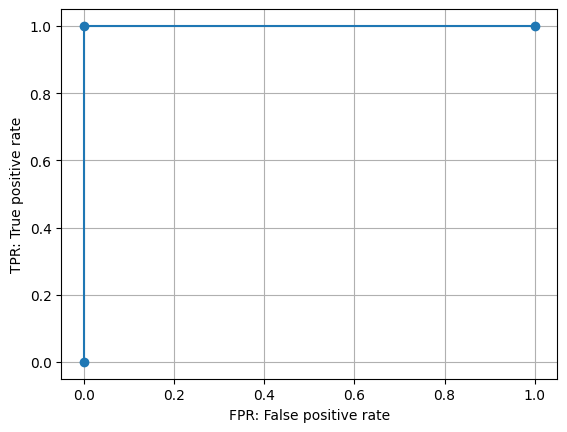

In [56]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 評価項目

In [57]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率：実際に真だったもののうち、モデルが真と判断した割合。
# 見逃しをなくしたいときに使われる。
# 別名真陽性率。
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)
# 適合率：モデルが真と判断し、実際に真だった割合。猫と判断し、実際に猫だった割合。
# 誤検出をなくしたいときに使われる。
precision_per_class = cm.diagonal() / cm.sum(axis=0)
val_precision_per_class = val_cm.diagonal() / val_cm.sum(axis=0)
print(precision_per_class)
print(val_precision_per_class)
# F1スコア：適合率と再現率の調和平均。
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
val_f1_per_class = 2 * (val_precision_per_class * val_recall_per_class) / (val_precision_per_class + val_recall_per_class)
print(f1_per_class)
print(val_f1_per_class)
# 偽陽性率：実際に偽だったったもののうち、モデルが間違えて真と判断した割合。

tensor(0.8709)
tensor(0.8139)
[[4475   32  131   39   49   17   15   28  150   64]
 [  35 4716   10   13    6   12   11    4   44  149]
 [ 177    9 4085  156  171  140  150   70   29   13]
 [  48    5  167 3778  167  505  181   87   34   28]
 [  46    0  167  153 4294  110   74  130   17    9]
 [  23    5  128  563  133 3935   60  132   10   11]
 [  23    8  127  170   86   49 4513    6    8   10]
 [  26    4   73  131  158  120   13 4453    6   16]
 [ 142   56   27   21   13    9   11    7 4660   54]
 [  73  154   14   31    7    9    8   15   45 4644]]
[[839   8  35  14  10   4   7   7  45  31]
 [ 13 894   1   5   1   3   3   2  20  58]
 [ 41   1 732  41  61  45  43  23   8   5]
 [ 16   3  49 654  46 144  39  28  10  11]
 [ 15   1  42  47 809  20  27  32   6   1]
 [  6   5  31 149  38 718  15  28   7   3]
 [  6   2  39  54  17  13 861   4   2   2]
 [ 12   2  28  24  39  45   1 841   2   6]
 [ 41  13   9   7   2   5   2   4 901  16]
 [ 13  48   6   9   1   2   1  10  22 888]]
[0.895  

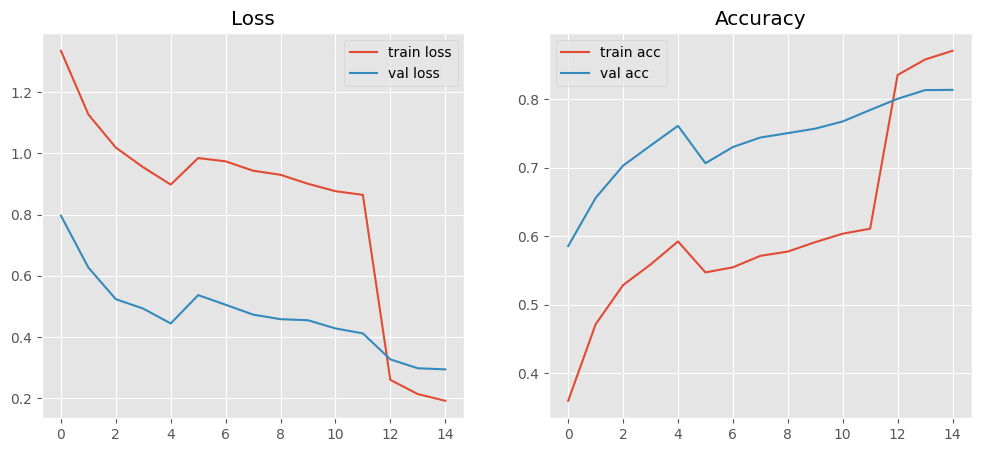

In [58]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [59]:
print(accs)
print(val_accs)

[tensor(0.3600), tensor(0.4717), tensor(0.5289), tensor(0.5590), tensor(0.5926), tensor(0.5474), tensor(0.5548), tensor(0.5716), tensor(0.5778), tensor(0.5916), tensor(0.6039), tensor(0.6112), tensor(0.8356), tensor(0.8582), tensor(0.8709)]
[tensor(0.5859), tensor(0.6562), tensor(0.7033), tensor(0.7325), tensor(0.7614), tensor(0.7068), tensor(0.7304), tensor(0.7443), tensor(0.7507), tensor(0.7573), tensor(0.7678), tensor(0.7845), tensor(0.8008), tensor(0.8135), tensor(0.8139)]


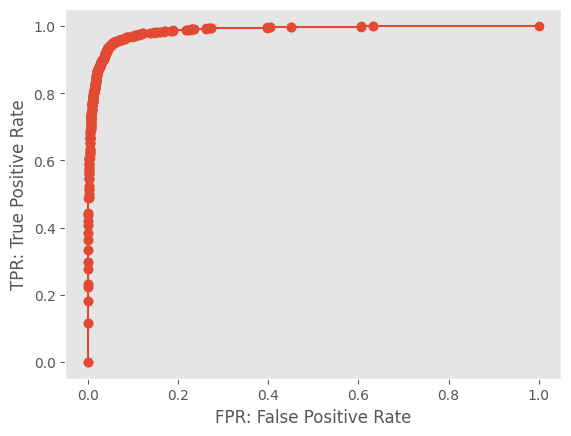

In [60]:
# y_val_true はラベル（0 or 1）を含むリスト
y_val_true = torch.tensor(y_val_true)

# val_output に softmax を適用
val_output_tensor = torch.cat([model(val_imgs.to(device)) for val_imgs, _ in validation_dataloader])
val_prob_pred = torch.softmax(val_output_tensor, dim=1)

# クラス0の確率値を取得
prob = val_prob_pred[:, 0].cpu().detach().numpy()

# 0/1 ラベルの取得
one_zero_labels = torch.where(y_val_true == 0, 1, 0).cpu().detach().numpy()

# ROC曲線の計算
fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

# グラフ描画
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False Positive Rate')
plt.ylabel('TPR: True Positive Rate')
plt.grid()
plt.show()


ROC AUC Score: 0.9856
ROC AUC Score: 0.9955
ROC AUC Score: 0.9660
ROC AUC Score: 0.9494
ROC AUC Score: 0.9813
ROC AUC Score: 0.9653
ROC AUC Score: 0.9890
ROC AUC Score: 0.9886
ROC AUC Score: 0.9922
ROC AUC Score: 0.9924


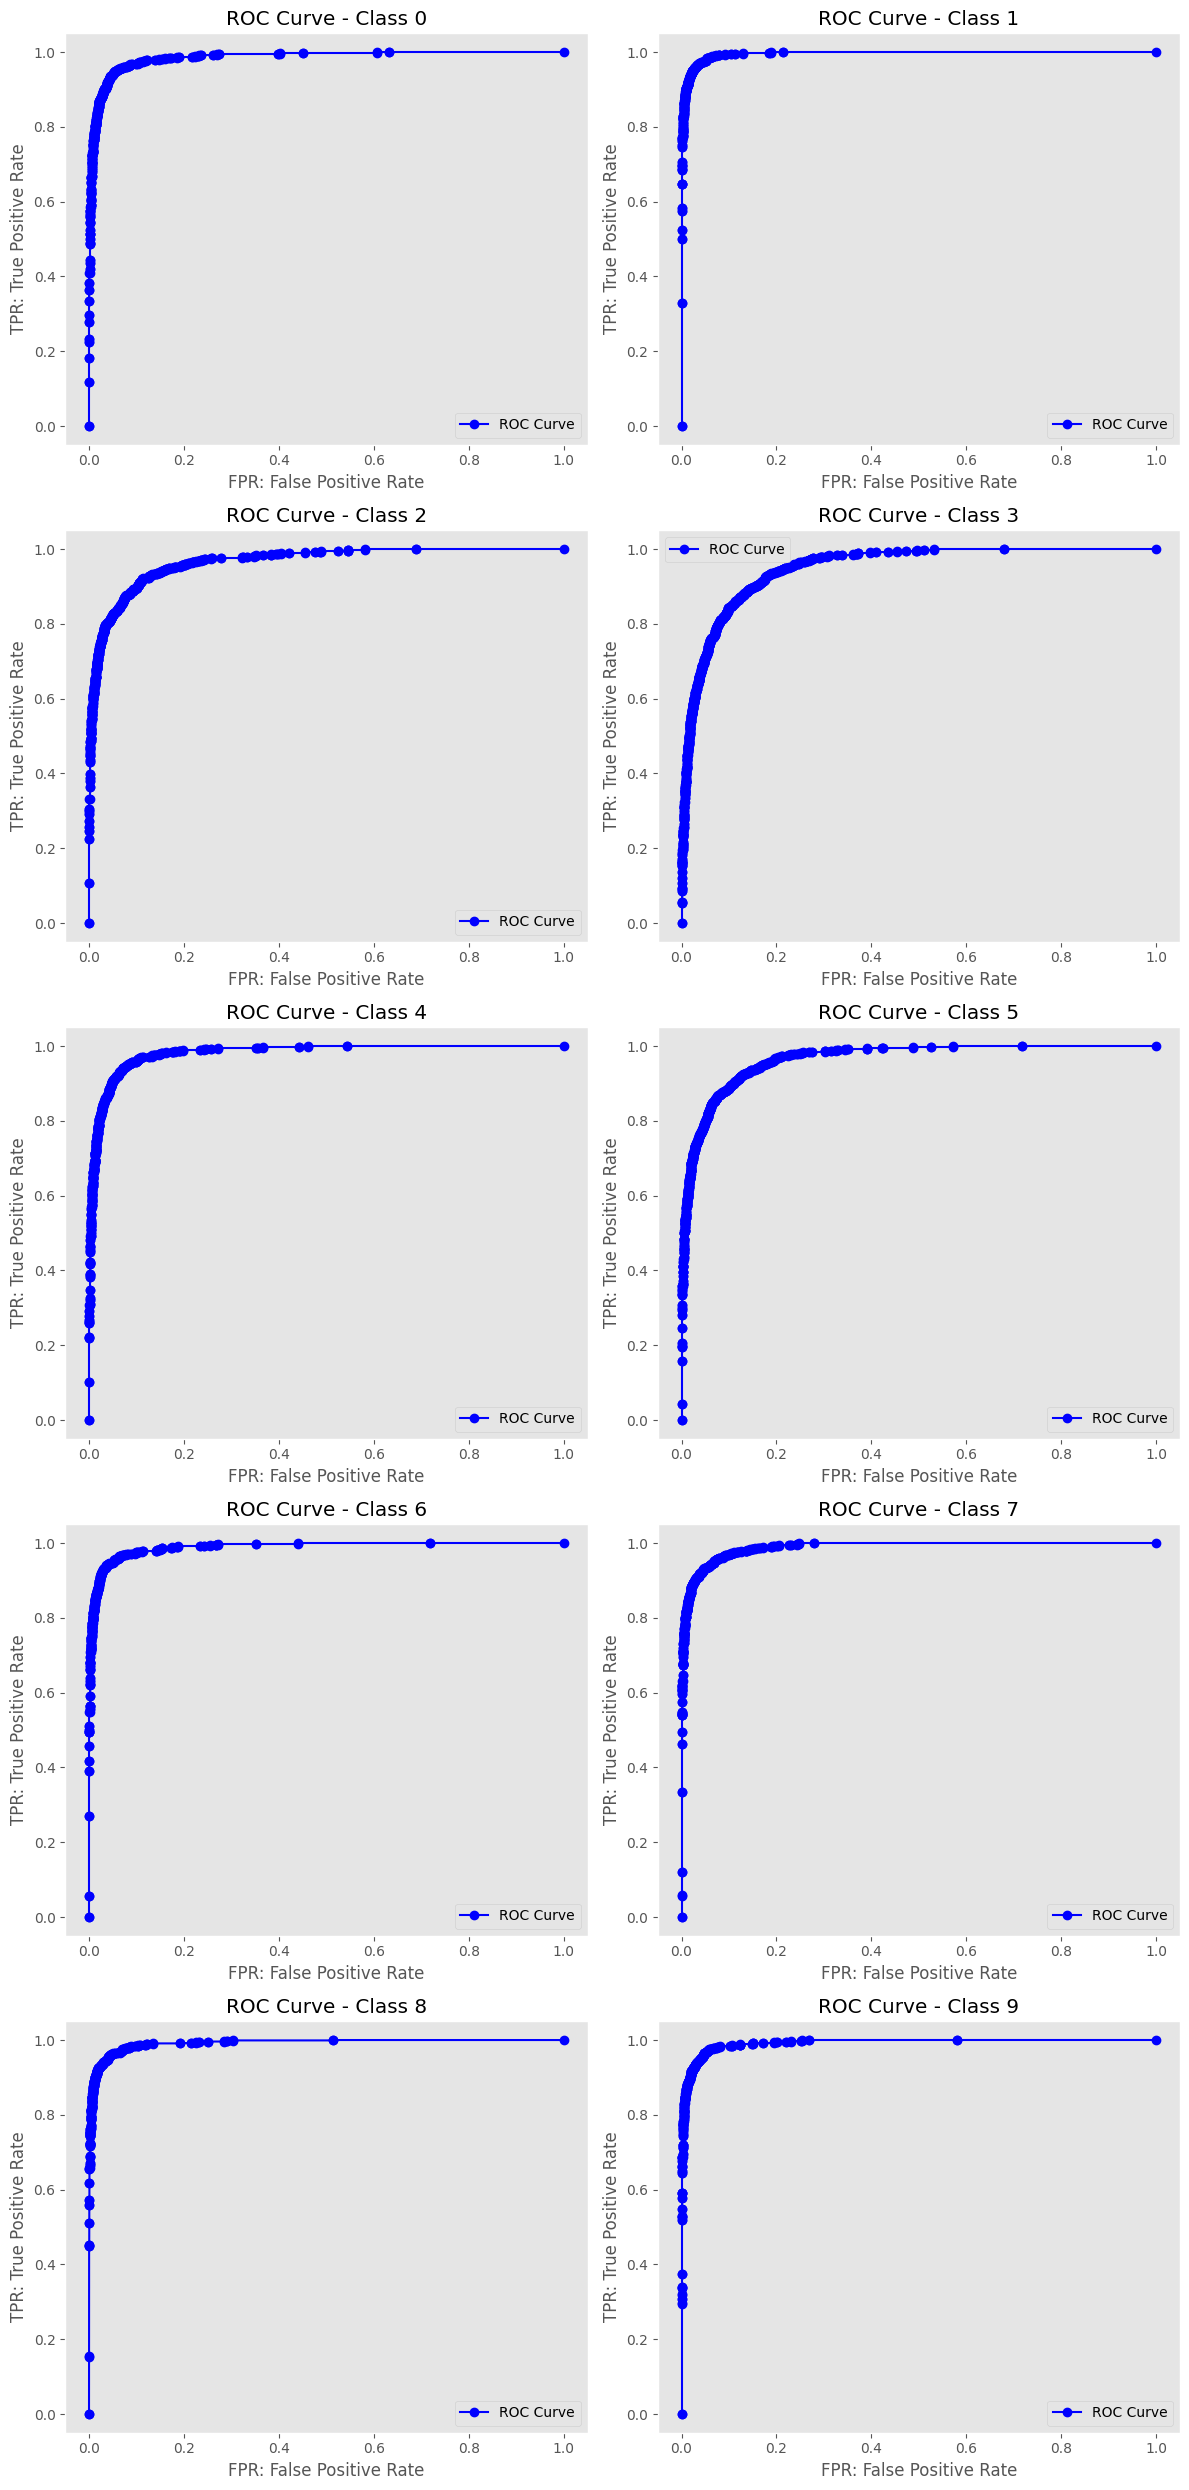

In [61]:
def make_roc_curve():
    fig, axes = plt.subplots(5, 2, figsize=(12, 25))  # 5行2列のサブプロット

    for n in range(10):

        # クラス0の確率値を取得
        prob = val_prob_pred[:, n].cpu().detach().numpy()

        # 0/1 ラベルの取得
        one_zero_labels = torch.where(y_val_true == n, 1, 0).cpu().detach().numpy()

        # ROC曲線の計算
        fpr, tpr, thresholds = roc_curve(one_zero_labels, prob)

        # auc算出
        auc_score = roc_auc_score(one_zero_labels, prob)
        print(f"ROC AUC Score: {auc_score:.4f}")

        # 行インデックスと列インデックスの計算
        row_idx = n // 2  # 行インデックス
        col_idx = n % 2   # 列インデックス

        # グラフ描画
        axes[row_idx, col_idx].plot(fpr, tpr, marker='o', color='b', label="ROC Curve")
        axes[row_idx, col_idx].set_xlabel('FPR: False Positive Rate')
        axes[row_idx, col_idx].set_ylabel('TPR: True Positive Rate')
        axes[row_idx, col_idx].set_title(f'ROC Curve - Class {n}')
        axes[row_idx, col_idx].legend()
        axes[row_idx, col_idx].grid()
    plt.tight_layout()
    plt.show()

make_roc_curve()